## Learning Convolutional Kernels with MIP

In [1]:
import numpy as np
from docplex.mp.model import Model

def kernel_mip(tensor, tau):
    model = Model(name = 'Sparse Autoregression')
    M, N, T = tensor.shape
    w = [model.continuous_var(lb = 0, name = f'w_{k}') for k in range(T - 1)]
    beta = [model.binary_var(name = f'beta_{k}') for k in range(T - 1)]
    error = [tensor[m, n, t] - model.sum(w[k] * tensor[m, n, t - k - 1] for k in range(T - 1))
             for m in range(M) for n in range(N) for t in range(T)]
    model.minimize(model.sum(r ** 2 for r in error))
    model.add_constraint(model.sum(beta[k] for k in range(T - 1)) <= tau)
    model.add_constraint(model.sum(w[k] for k in range(T - 1)) == 1)
    for k in range(T - 1):
        model.add_constraint(w[k] <= beta[k])
    solution = model.solve()
    if solution:
        print(solution.get_values(w))
        w_coef = np.array(solution.get_values(w))
        error = 0
        for m in range(M):
            for n in range(N):
                for t in range(T):
                    a = tensor[m, n, t]
                    for k in range(T - 1):
                        a -= w_coef[k] * tensor[m, n, t - k - 1]
                    error += a ** 2
        print('Objective function: {}'.format(error))
        ind = np.where(w_coef > 0)[0].tolist()
        print('Support set: ', ind)
        print('Coefficients w: ', w_coef[ind])
        print('Cardinality of support set: ', len(ind))
        return w_coef, ind
    else:
        print('No solution found.')
        return None

## Fluid Flow Dataset

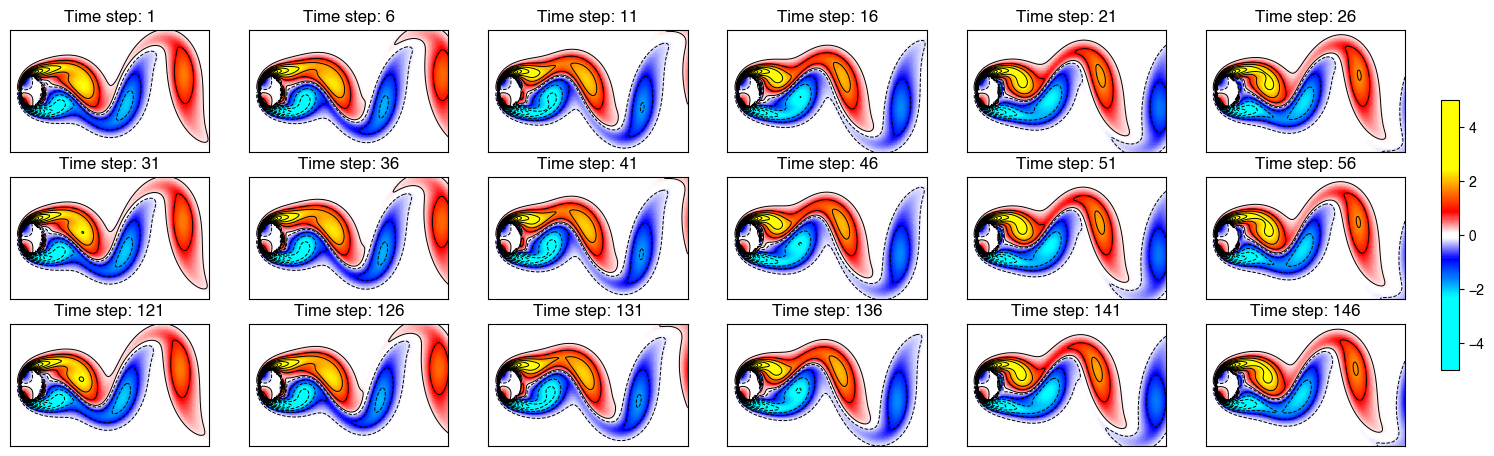

In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

plt.rc('font', family = 'Helvetica')
color = scipy.io.loadmat('../Fluid-flow/CCcool.mat')
cc = color['CC']
newcmp = LinearSegmentedColormap.from_list('', cc)
tensor = np.load('../Fluid-flow/tensor.npz')['arr_0']
tensor = tensor[:, :, : 150]
M, N, T = tensor.shape

fig = plt.figure(figsize = (18, 3.6 * 1.5))
i = 0
for t in range(0, 60, 5):
    ax = fig.add_subplot(3, 6, i + 1)
    sns.heatmap(tensor[:, :, t], cmap = newcmp, vmin = -5, vmax = 5, cbar = False)
    ax.contour(np.linspace(0, N, N), np.linspace(0, M, M), tensor[:, :, t], 
               levels = np.linspace(0.15, 15, 20), colors = 'k', linewidths = 0.7)
    ax.contour(np.linspace(0, N, N), np.linspace(0, M, M), tensor[:, :, t], 
               levels = np.linspace(-15, -0.15, 20), colors = 'k', linestyles = 'dashed', linewidths = 0.7)
    plt.title('Time step: {}'.format(t + 1))
    plt.xticks([])
    plt.yticks([])
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    i += 1
for t in range(120, 150, 5):
    ax = fig.add_subplot(3, 6, i + 1)
    sns.heatmap(tensor[:, :, t], cmap = newcmp, vmin = -5, vmax = 5, cbar = False)
    ax.contour(np.linspace(0, N, N), np.linspace(0, M, M), tensor[:, :, t], 
               levels = np.linspace(0.15, 15, 20), colors = 'k', linewidths = 0.7)
    ax.contour(np.linspace(0, N, N), np.linspace(0, M, M), tensor[:, :, t], 
               levels = np.linspace(-15, -0.15, 20), colors = 'k', linestyles = 'dashed', linewidths = 0.7)
    plt.title('Time step: {}'.format(t + 1))
    plt.xticks([])
    plt.yticks([])
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    i += 1
cbar_ax = fig.add_axes([0.92, 0.25, 0.01, 0.5])  # [left, bottom, width, height]
fig.colorbar(ax.collections[0], cax = cbar_ax)
plt.show()
# fig.savefig('fluid_flow_snapshots.png', bbox_inches = 'tight')

## Experiment

In [3]:
import numpy as np
import time

tensor = np.load('../Fluid-flow/tensor.npz')['arr_0']
tensor = tensor[100 : 120, 200 : 220, : 150]
tau = 4

start = time.time()
w, ind = kernel_mip(tensor, tau)
end = time.time()
print('Running time (s):', end - start)

[0.338359894400062, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16164010559998224, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.16164010559989395, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3383598944000618]
Objective function: 381.4318379491275
Support set:  [0, 29, 119, 148]
Coefficients w:  [0.33835989 0.16164011 0.16164011 0.33835989]
Cardinality of support set:  4
Running time (s): 1406.7912509441376


### License

<div class="alert alert-block alert-danger">
<b>This work is released under the MIT license.</b>
</div>